# TP 4 : Improve the Metropolis-Hastings algorithm

In [1]:
import numpy as np
import pylab as pl

## Exercise 3: Bayesian analysis of a one-way random effects model

Here are the implementations of the two Gibbs samplers proposed

In [2]:
def invgamma(a, b):
    return 1 / np.random.gamma(a, 1/b)

In [3]:
def gibbs(y, alpha, beta, gamma, n):
    """
    Sample n quadruplets (sigma2, tau2, mu, X) using Gibbs sampling on blocks:
    sigma2 then tau2 then mu then X
    The sampling is done thanks to the observations y where y is a liste of N arrays
    and y[i] is the array of size k_i containing all y_{ij}
    alpha, beta, gamma are the hyperparameters

    The result is a list of four arrays. One array for each unknown parameter/value
    sigma2, tau2, mu and X. Each array has size n.
    """
    N = len(y)
    k = np.array([len(yi) for yi in y])
    K = k.sum()
    sigma2 = invgamma(alpha, beta)
    tau2 = invgamma(gamma, beta)
    sy = np.array([yi.sum() for yi in y])
    mu = (sy / k).mean()
    def getX():
        s2 = 1 / (1/sigma2 + k/tau2)
        return np.random.normal(s2*(mu/sigma2 + sy/tau2), s2 ** 0.5, N)
    X = getX()
    samples = []
    for _ in range(n):
        sigma2 = invgamma(alpha + N/2, beta + 0.5*((X - mu)**2).sum())
        tau2 = invgamma(gamma + K/2, beta + 0.5*sum(((X[i] - y[i])**2).sum() for i in range(N)))
        mu = np.random.normal(X.mean(), (sigma2/N) ** 0.5)
        X = getX()
        samples.append((sigma2, tau2, mu, X))
    return [np.array([s[i] for s in samples]) for i in range(4)]

In [4]:
def gibbs_block(y, alpha, beta, gamma, n):
    """
    Sample n quadruplets (sigma2, tau2, mu, X) using Gibbs sampling on blocks:
    sigma2 then tau2 then (X, mu)
    The sampling is done thanks to the observations y where y is a liste of N arrays
    and y[i] is the array of size k_i containing all y_{ij}
    alpha, beta, gamma are the hyperparameters
    
    The result is a list of four arrays. One array for each unknown parameter/value
    sigma2, tau2, mu and X. Each array has size n.
    """
    N = len(y)
    k = np.array([len(yi) for yi in y])
    K = k.sum()
    sigma2 = invgamma(alpha, beta)
    tau2 = invgamma(gamma, beta)
    my = np.array([yi.mean() for yi in y])
    def getXmu():
        X = np.random.normal(my, tau2/k)
        mu = np.random.normal(X.mean(), (sigma2/N) ** 0.5)
        return X, mu
    X, mu = getXmu()
    samples = []
    for _ in range(n):
        sigma2 = invgamma(alpha + N/2, beta + 0.5*((X - mu)**2).sum())
        tau2 = invgamma(gamma + K/2, beta + 0.5*sum(((X[i] - y[i])**2).sum() for i in range(N)))
        X, mu = getXmu()
        samples.append((sigma2, tau2, mu, X))
    return [np.array([s[i] for s in samples]) for i in range(4)]

Now we define a function to mesure auto correlation

In [5]:
def auto_corr(s, tmax=None):
    if tmax is None: tmax = len(s)
    else: tmax = min(len(s), tmax)
    return np.array([np.corrcoef(s[i:], s[:-i])[0,1] for i in range(1, tmax)])

In [31]:
##### PARAMETERS ####
alpha = 3
beta = 5
gamma = 100
N = 30
# k_i is chosen uniformly in {kmin, ..., kmax-1}
kmin, kmax = 3, 10
#####################
assert alpha > 2 and gamma > 1
assert kmin < kmax

#### Dataset Generation ####
sigma = invgamma(alpha, beta) ** 0.5
tau = invgamma(gamma, beta) ** 0.5
mu = np.random.normal(0, beta**2 / (alpha - 1)**2 / (alpha - 2))
k = np.random.randint(kmin, kmax, N)
x = np.random.normal(mu, sigma, N)
y = [x[i] + np.random.normal(0, tau, k[i]) for i in range(N)]
print("E[sigma^2]:", beta/(alpha-1), "\nVar[sigma^2]:", beta**2 / (alpha - 1)**2 / (alpha - 2))
print("E[tau^2]:", beta/(gamma-1), "\nVar[tau^2]:", beta**2 / (gamma - 1)**2 / (gamma - 2))
print("===================================")
print("==== Drawn Unknown Parameters =====")
print("===================================")
print("sigma^2:", sigma**2, "\ntau^2:", tau**2, "\nmu:", mu)

E[sigma^2]: 2.5 
Var[sigma^2]: 6.25
E[tau^2]: 0.050505050505050504 
Var[tau^2]: 2.6028164556303082e-05
==== Drawn Unknown Parameters =====
sigma^2: 3.004594039556646 
tau^2: 0.043435096009149125 
mu: -2.472069043698527


Here we plot the observations y at ordinate 0.1 and the random effects x at ordinate 0.0  
The observations has the same color as the random effects to which they are associated

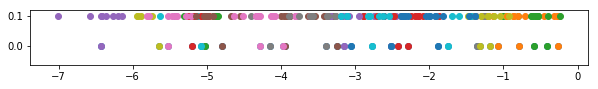

In [32]:
pl.figure(figsize=(10, 1))
pl.scatter(x, np.zeros(N))
for i in range(N):
    pl.scatter(list(y[i]) + [x[i]], [0.1]*k[i] + [0])

In [33]:
##### PARAMETERS ####
n = 500
#####################
labels = ["sigma^2", "tau^2", "mu"]

### Results with the first Gibbs Sampler

In [34]:
ss, ts, ms, xs = gibbs(y, alpha, beta, gamma, n)
print("sigma^2:", ss.mean(), "+-", ss.var()**0.5, "\t\tVar =", ss.var())
print("tau^2:", ts.mean(), "+-", ts.var()**0.5, "\t\tVar =", ts.var())
print("mu:", ms.mean(), "+-", ms.var()**0.5, "\t\tVar =", ms.var())

sigma^2: 3.028303893230495 +- 0.7511842761222272 		Var = 0.5642778166932744
tau^2: 0.04598673512324568 +- 0.0034516045800966713 		Var = 1.191357417734432e-05
mu: -2.9894728773485055 +- 0.31835473786960183 		Var = 0.1013497391240229


Mean of absolute auto-correlation: 0.04458933040124537


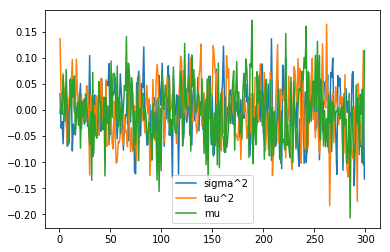

In [35]:
tmax = int(0.6*n)
correls = np.array([auto_corr(s, tmax) for s in [ss, ts, ms]])
print("Mean of absolute auto-correlation:", abs(correls).mean())
t = list(range(1, tmax))
for c, l in zip(correls, labels):
    pl.plot(t, c, label=l)
pl.legend()
pl.show()

### Results with the second Gibbs Sampler (Block)

In [36]:
ss, ts, ms, xs = gibbs_block(y, alpha, beta, gamma, n)
print("sigma^2:", ss.mean(), "+-", ss.var()**0.5, "\t\tVar =", ss.var())
print("tau^2:", ts.mean(), "+-", ts.var()**0.5, "\t\tVar =", ts.var())
print("mu:", ms.mean(), "+-", ms.var()**0.5, "\t\tVar =", ms.var())

sigma^2: 3.0438749291346427 +- 0.7418458417735609 		Var = 0.5503352529567233
tau^2: 0.04233970847567197 +- 0.002996670205617036 		Var = 8.980032321232849e-06
mu: -3.006628176470285 +- 0.3213898651625701 		Var = 0.10329144542921499


Mean of absolute auto-correlation: 0.044512518924897014


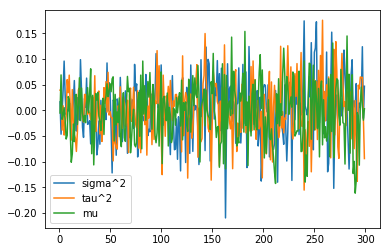

In [37]:
tmax = int(0.6*n)
correls = np.array([auto_corr(s, tmax) for s in [ss, ts, ms]])
print("Mean of absolute auto-correlation:", abs(correls).mean())
t = list(range(1, tmax))
for c, l in zip(correls, labels):
    pl.plot(t, c, label=l)
pl.legend()
pl.show()